# 1. Introduction

## Predicting Player Elo from Opening Moves

### Project Overview
The aim is, to use the Lichess Standard Rated Games Dataset, publicly available on Huggingface (https://huggingface.co/datasets/Lichess/standard-chess-games) to build regression models that predict a player’s Elo rating based solely on the first _n_ moves of a game. By focusing on opening patterns, our goal is to uncover which early-game features best correlate with player strength. The underlying hypothesis is that players more experienced with chess will adhere more strictly to certain established chess openings.

### Data Source
- **Dataset**: Lichess Standard Rated Games
    - Structured by Year and Month
    - Around 20-30GB of Data per month
    - Provided as .parquet files, easily convertable to pgn
- **Key Fields**:
  - `UTCDate`, `UTCTime`
  - `White`, `Black`
  - `WhiteElo`, `BlackElo` (target variables)
  - `movetext` (contains PGN moves)

### Pipeline
1. **Data Extraction**
   - Stream only the desired month’s Parquet partitions
      - Find out what amount of data is managable
   - Filter out incomplete or abnormal games
   - Reduce DataFrame to key fields for analysis
2. **Feature Engineering**
   - Parse `movetext` to extract the first _n_ half‑moves (e.g. 10 plies)
   - Encode moves as categorical sequences, opening ECO codes, or vectorized embeddings
   - Optional: Include auxiliary features: time control, rating differences, termination type
3. **Modeling**
   - Train regression algorithms (e.g. linear regression, random forest)
   - Cross‑validate on different `_n_` to see how many moves are needed for accurate Elo estimates
4. **Evaluation**
   - Measure performance via RMSE and R² on held‑out data
   - Analyze feature importances to identify key opening moves or patterns

# 2. Data Loading and Exploration

In [14]:
from datasets import load_dataset
import pandas as pd
import re


In [2]:
# pick your year & month
year, month = 2025, 4
month_str = f"{month:02d}"
num_games = 50000
# define date period to be downloaded
data_files = {
    "games": f"https://huggingface.co/datasets/lichess/standard-chess-games/resolve/main/data/year={year}/month={month_str}/*.parquet"
}

ds = load_dataset(
    "parquet",
    data_files=data_files,
    split="games",
    streaming=True
)

# load first N games into DataFrame
sample = pd.DataFrame([x for _, x in zip(range(num_games), ds)])
#sample = sample[sample["Termination"] == 'Normal']
#print(len(sample))
#sample = sample[sample["TimeControl"] == '600+0']
#print(len(sample))

#can i even use lienar models, as moevs are not independent?
# maybe use transformer like in optformer?
#TODO clean data
# decide on time format (blitz, rapid..)
# include aborted or time foreit games?
# min length?
# what exactly should the input be? how to split input string
# make sure dataset is representative? what does this mean, elos should be normally distributed or same amount for each elo-span?



Resolving data files:   0%|          | 0/65 [00:00<?, ?it/s]

In [55]:
cols =[
    #'Event',
    #'Site',
    #'White',
    #'Black',
    'Result', #{'0-1', '1-0', '*', '1/2-1/2'}
    #'WhiteTitle',
    #'BlackTitle',
    #'WhiteElo',
    #'BlackElo',
    #'WhiteRatingDiff',
    #'BlackRatingDiff',
    #'UTCDate',
    #'UTCTime',
    #'ECO',
    'Opening',
    'Termination', # {'Unterminated', 'Normal', 'Abandoned', 'Rules infraction', 'Time forfeit'}
    'TimeControl',
    #'movetext'
    ]

games = sample['movetext']
games = games[:5000]
# 2) Find every move‑string in order:
#    - castling: O-O or O-O-O
#    - or standard SAN: optional piece letter, file/rank, optional x/capture, optional =promotion, optional +# check/mate
pattern = r'\bO-O(?:-O)?\b|[PNBRQK]?[a-h][1-8](?:=[NBRQ])?[+#]?'

moves_cleaned = []
for game in games:
    # 1) Strip out all { … } plus any extra spaces around them
    no_clock = re.sub(r'\s*\{[^}]*\}\s*', ' ', game)
    moves_cleaned.append(re.findall(pattern, no_clock))
print(moves_cleaned)

[['d3', 'e6', 'Nf3', 'd5', 'g3', 'c5', 'Bg2', 'Be7', 'O-O', 'Nf6', 'c4', 'Nc6', 'Nc3', 'd4', 'Ne4', 'e4', 'e4', 'e5', 'a3', 'f6', 'Rb1', 'a5', 'Bd2', 'a4', 'b4', 'b3', 'b3', 'Qc7', 'e3', 'O-O', 'd4', 'd4', 'd4', 'd4', 'Bb4', 'Re8', 'd1', 'Bf8', 'Rd3', 'Be6', 'Rc1', 'c8', 'Bf1', 'b5', 'f8', 'c4', 'Qb4', 'f8', 'Rf3', 'Bg4', 'c4+', 'c4', 'c4', 'f3', 'c8', 'c8', 'Qb3+', 'Kf8', 'f3', 'Rc1+', 'Kg2', 'Ra1', 'h4', 'Kf7', 'Qb3+', 'Kg6', 'Kf3', 'h5', 'g4', 'g4+', 'g4', 'Rg1+', 'Kf3', 'Kh5', 'Qb7', 'h4', 'Qf7', 'Rg4', 'Qg8', 'Rg6', 'Qh8+', 'Rh6', 'Qg8', 'g5', 'Qf7', 'Kh3', 'Ke2', 'Kh2', 'Qe6', 'Kg1', 'Qc4', 'Rh3', 'Qd3', 'd3', 'd3', 'f2', 'a4', 'g4', 'a5', 'g3', 'a6', 'g2', 'a7', 'g1=Q'], ['a4', 'e5', 'h4', 'Nc6', 'c3', 'Nf6', 'a5', 'h6', 'h5', 'a6', 'f3', 'Bc5', 'Qb3', 'd6', 'e3', 'Rb8', 'g4', 'Be6', 'Qc2', 'Qd7', 'g5', 'g5', 'h6', 'h6', 'h6', 'h6', 'Nh3', 'h3', 'h3', 'h3', 'd4', 'Ba7', 'Qb3', 'Qe6', 'e4', 'd4', 'e6+', 'e6', 'g5', 'Nh7', 'Bf4', 'f3', 'Bh6', 'e5', 'Bg7', 'Kf7', 'Bh6', 'Rg8', 'd4'

In [57]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# assume moves_cleaned is List[List[str]]

max_N = 20
move_cols = [f"move_{i+1}" for i in range(max_N)]

padded_moves = []
for moves in moves_cleaned:
    if len(moves) >= max_N:
        # keep only the first ten
        trimmed = moves[:max_N]
    else:
        # pad short games
        trimmed = moves + ["<PAD>"] * (max_N - len(moves))
    padded_moves.append(trimmed)

# build DataFrame
moves_expanded = pd.DataFrame(padded_moves, columns=move_cols)
print(f"Total games: {len(moves_expanded)}")

# one‑hot encode
ohe = OneHotEncoder(sparse_output=True, handle_unknown="ignore")
X_sparse = ohe.fit_transform(moves_expanded)
print(f"Feature matrix shape: {X_sparse.shape}")



Total games: 5000
Feature matrix shape: (5000, 3085)


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import Ridge
from sklearn.metrics         import mean_squared_error, r2_score
import numpy as np
l = sample.iloc[:5000]
y_elo = l['WhiteElo'].values
X_train, X_test, y_train, y_test = train_test_split(
    X_sparse, y_elo, test_size=0.2, random_state=42
)

# ─── 4. Fit Ridge regression ─────────────────────────────────────────────────
ridge = Ridge(alpha=1.0)       # you can grid‑search alpha via cross‑val
ridge.fit(X_train, y_train)

# ─── 5. Evaluate ──────────────────────────────────────────────────────────────
y_pred = ridge.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²:   {r2:.3f}")

Test RMSE: 422.13
Test R²:   -0.126


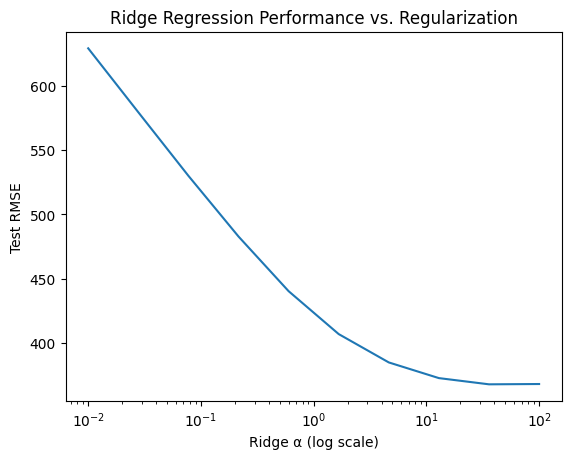

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model    import Ridge
from sklearn.metrics         import mean_squared_error
from sklearn.model_selection import train_test_split

# -- assume X_sparse, y_elo exist from your preprocessing pipeline --

# 1) Split once
X_train, X_test, y_train, y_test = train_test_split(
    X_sparse, y_elo, test_size=0.2, random_state=42
)

# 2) Sweep a range of alphas
alphas = np.logspace(-2, 2, 10)   # [0.01, 0.1, 1, 10, 100], etc.
rmses  = []
for α in alphas:
    mdl = Ridge(alpha=α)
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    rmses.append(np.sqrt(mean_squared_error(y_test, y_pred)))

# 3) Plot
plt.figure()
plt.plot(alphas, rmses)
plt.xscale('log')
plt.xlabel('Ridge α (log scale)')
plt.ylabel('Test RMSE')
plt.title('Ridge Regression Performance vs. Regularization')
plt.show()


Test RMSE: 422.13
Test R²:   -0.126
Accuracy (@±100 Elo): 16.6%


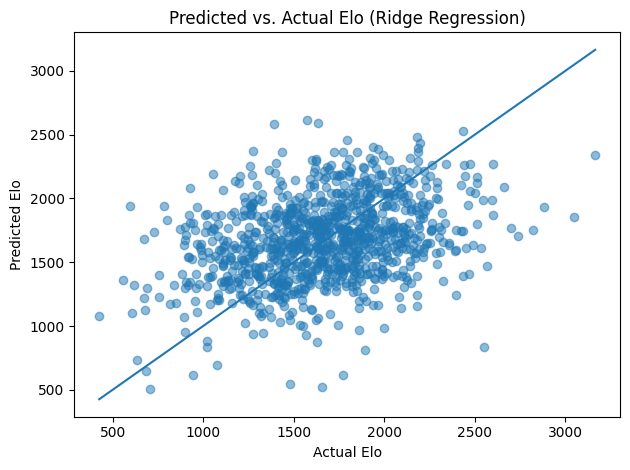

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# -- assume X_sparse, y_elo exist from your preprocessing pipeline --

# 1) Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_sparse, y_elo, test_size=0.2, random_state=42
)

# 2) Fit final Ridge (choose alpha from CV; here we use alpha=1.0)
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

# 2) “Accuracy” within a tolerance window
tolerance = 100  # Elo points
accuracy_within_tol = np.mean(np.abs(y_pred - y_test) <= tolerance)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²:   {r2:.3f}")
print(f"Accuracy (@±{tolerance} Elo): {accuracy_within_tol*100:.1f}%")

# 3) Scatter plot of Actual vs Predicted
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.5)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims)                     # 45° line
plt.xlabel("Actual Elo")
plt.ylabel("Predicted Elo")
plt.title("Predicted vs. Actual Elo (Ridge Regression)")
plt.tight_layout()
plt.show()


/Users/lucathale-bombien/PycharmProjects/Probabilistic-Machine-Learning_lecture-PROJECTS/snetuna/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 17.50%
Mean abs. bin error: 1.79 bins (~358 Elo)
Cohen's weighted kappa: 0.121


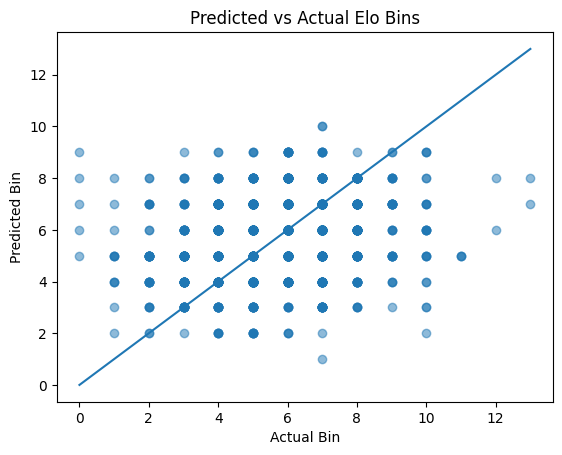

In [62]:
# Code snippet: Ordinal classification pipeline with plot and metrics

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, cohen_kappa_score
from sklearn.linear_model import LogisticRegression

# Assume X_sparse and y_elo are already defined

# 1. Create ordinal bins (200-point)
elo_min, elo_max = y_elo.min(), y_elo.max()
edges = np.arange(elo_min, elo_max + 200, 200)
y_cat = np.digitize(y_elo, edges) - 1

# 2. Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(X_sparse, y_cat,
                                         test_size=0.2, random_state=42)

# 3. Fit multinomial logistic as ordinal proxy
clf = LogisticRegression(multi_class='multinomial', max_iter=1000)
clf.fit(X_tr, y_tr)
y_pred = clf.predict(X_te)

# 4. Metrics
acc = accuracy_score(y_te, y_pred)
mae = mean_absolute_error(y_te, y_pred)
kappa = cohen_kappa_score(y_te, y_pred, weights='linear')

print(f"Accuracy: {acc*100:.2f}%")
print(f"Mean abs. bin error: {mae:.2f} bins (~{mae*200:.0f} Elo)")
print(f"Cohen's weighted kappa: {kappa:.3f}")

# 5. Plot predicted vs actual bins
plt.figure()
plt.scatter(y_te, y_pred, alpha=0.5)
lims = [min(y_te.min(), y_pred.min()),
        max(y_te.max(), y_pred.max())]
plt.plot(lims, lims)
plt.xlabel("Actual Bin")
plt.ylabel("Predicted Bin")
plt.title("Predicted vs Actual Elo Bins")
plt.show()


/Users/lucathale-bombien/PycharmProjects/Probabilistic-Machine-Learning_lecture-PROJECTS/snetuna/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/100, Train MSE: 2891489.34
Epoch 2/100, Train MSE: 2869388.42
Epoch 3/100, Train MSE: 2841635.97
Epoch 4/100, Train MSE: 2806687.24
Epoch 5/100, Train MSE: 2764823.99
Epoch 6/100, Train MSE: 2716264.93
Epoch 7/100, Train MSE: 2661352.21
Epoch 8/100, Train MSE: 2600345.04
Epoch 9/100, Train MSE: 2533658.01
Epoch 10/100, Train MSE: 2461809.77
Epoch 11/100, Train MSE: 2385206.84
Epoch 12/100, Train MSE: 2304410.28
Epoch 13/100, Train MSE: 2219950.46
Epoch 14/100, Train MSE: 2132468.38
Epoch 15/100, Train MSE: 2042522.20
Epoch 16/100, Train MSE: 1950675.59
Epoch 17/100, Train MSE: 1857459.40
Epoch 18/100, Train MSE: 1763505.60
Epoch 19/100, Train MSE: 1669427.94
Epoch 20/100, Train MSE: 1575543.05
Epoch 21/100, Train MSE: 1482545.27
Epoch 22/100, Train MSE: 1391011.53
Epoch 23/100, Train MSE: 1301223.86
Epoch 24/100, Train MSE: 1213735.68
Epoch 25/100, Train MSE: 1128586.18
Epoch 26/100, Train MSE: 1046531.89
Epoch 27/100, Train MSE: 967735.28
Epoch 28/100, Train MSE: 892408.74
Epo

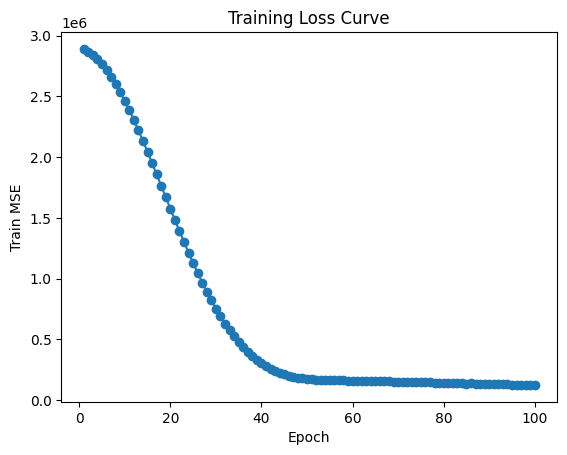

Test RMSE: 393.39
Test R²:   0.022
Accuracy (@±100 Elo): 20.2%


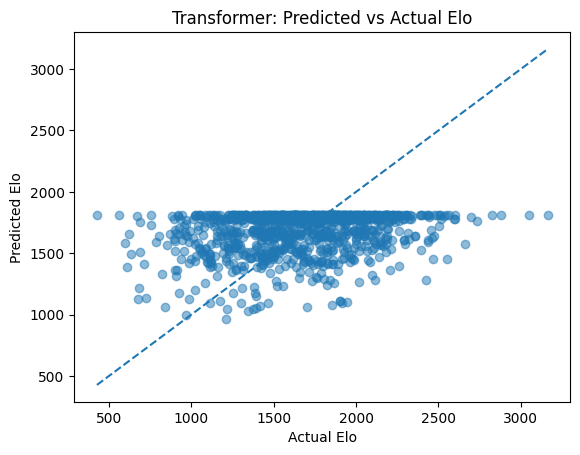

In [64]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# -- 1. Prepare data: assume moves_list and y_elo exist --
# moves_list: List[List[str]], y_elo: np.array of shape (n_games,)
# For self-contained demonstration, replace with your data variables.

# Example:
# moves_list = sample['moves'].tolist()
# y_elo = sample['WhiteElo'].values

# 1a. Limit to first 10 moves and pad
max_len = 20
processed_moves = []
for mv in moves_cleaned:
    if len(mv) >= max_len:
        processed_moves.append(mv[:max_len])
    else:
        processed_moves.append(mv + ["<PAD>"]*(max_len - len(mv)))

# 1b. Build vocabulary
unique_moves = sorted({m for game in processed_moves for m in game})
vocab = {move: idx+1 for idx, move in enumerate(unique_moves)}
vocab["<PAD>"] = 0
vocab_size = max(vocab.values()) + 1


# 1c. Encode sequences
encoded = np.array([[vocab[m] for m in game] for game in processed_moves])
y = y_elo.astype(np.float32)

# 1d. Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(encoded, y, test_size=0.2, random_state=42)

# -- 2. Dataset & DataLoader --
class ChessDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = ChessDataset(X_tr, y_tr)
test_ds  = ChessDataset(X_te, y_te)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)

# -- 3. Define Transformer model --
class EloTransformer(nn.Module):
    def __init__(self, vocab_size, emb_dim=64, n_heads=4, ff_dim=128, n_layers=2):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_heads, dim_feedforward=ff_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.regressor = nn.Linear(emb_dim, 1)

    def forward(self, x):
        emb = self.emb(x)  # (batch, seq_len, emb_dim)
        emb = emb.permute(1,0,2)  # (seq_len, batch, emb_dim)
        out = self.transformer(emb)
        out = out.permute(1,2,0)  # (batch, emb_dim, seq_len)
        pooled = self.pool(out).squeeze(-1)
        return self.regressor(pooled).squeeze(-1)

# Instantiate model, loss, optimizer
model = EloTransformer(vocab_size+1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -- 4. Training loop with loss tracking --
n_epochs = 100
train_losses = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_ds)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{n_epochs}, Train MSE: {epoch_loss:.2f}")

# Plot training loss over epochs
plt.figure()
plt.plot(range(1, n_epochs+1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Train MSE')
plt.title('Training Loss Curve')
plt.show()

# -- 5. Evaluation: RMSE, R², accuracy within ±100 Elo --
model.eval()
with torch.no_grad():
    preds, actuals = [], []
    for xb, yb in test_loader:
        p = model(xb)
        preds.append(p)
        actuals.append(yb)
    preds_all = torch.cat(preds).cpu().numpy()
    actuals_all = torch.cat(actuals).cpu().numpy()

rmse = np.sqrt(np.mean((preds_all - actuals_all)**2))
r2 = 1 - np.sum((preds_all-actuals_all)**2) / np.sum((actuals_all - actuals_all.mean())**2)
accuracy = np.mean(np.abs(preds_all - actuals_all) <= 100)  # within ±100 Elo

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²:   {r2:.3f}")
print(f"Accuracy (@±100 Elo): {accuracy*100:.1f}%")

# Scatter plot: Predicted vs Actual Elo
plt.figure()
plt.scatter(actuals_all, preds_all, alpha=0.5)
lims = [min(actuals_all.min(), preds_all.min()), max(actuals_all.max(), preds_all.max())]
plt.plot(lims, lims, '--')
plt.xlabel('Actual Elo')
plt.ylabel('Predicted Elo')
plt.title('Transformer: Predicted vs Actual Elo')
plt.show()


In [67]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

# -- 1. Prepare sequence data and bins --
# Assume moves_list (List[List[str]]) and y_elo (np.array) are defined

# 1a. Limit to first 10 moves, pad with "<PAD>"
max_len = 20
processed_moves = []
for mv in moves_cleaned:
    if len(mv) >= max_len:
        processed_moves.append(mv[:max_len])
    else:
        processed_moves.append(mv + ["<PAD>"]*(max_len - len(mv)))

# 1b. Build vocabulary
unique_moves = sorted({m for game in processed_moves for m in game})
vocab = {move: idx+1 for idx, move in enumerate(unique_moves)}
vocab["<PAD>"] = 0

# 1c. Encode sequences
encoded = np.array([[vocab[m] for m in game] for game in processed_moves])

# 1d. Create ordinal classes (200-point bins)
elo_min, elo_max = y_elo.min(), y_elo.max()
edges = np.arange(elo_min, elo_max + 200, 200)
y_classes = np.digitize(y_elo, edges) - 1  # class indices 0..C-1
num_classes = len(edges) - 1

# 1e. Train/test split
X_tr, X_te, y_tr_reg, y_te_reg, y_tr_cls, y_te_cls = train_test_split(
    encoded, y_elo, y_classes, test_size=0.2, random_state=42
)

# -- 2. Dataset & DataLoader --
class ChessMultiDataset(Dataset):
    def __init__(self, X, y_reg, y_cls):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y_reg = torch.tensor(y_reg, dtype=torch.float32)
        self.y_cls = torch.tensor(y_cls, dtype=torch.long)
    def __len__(self):
        return len(self.y_reg)
    def __getitem__(self, idx):
        return self.X[idx], self.y_reg[idx], self.y_cls[idx]

train_ds = ChessMultiDataset(X_tr, y_tr_reg, y_tr_cls)
test_ds  = ChessMultiDataset(X_te, y_te_reg, y_te_cls)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)

# -- 3. Define Transformer multi-task model --
class MultiTaskTransformer(nn.Module):
    def __init__(self, vocab_size, emb_dim=64, n_heads=4, ff_dim=128, n_layers=2, n_classes=10):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_heads, dim_feedforward=ff_dim, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.reg_head = nn.Linear(emb_dim, 1)
        self.cls_head = nn.Linear(emb_dim, n_classes)

    def forward(self, x):
        # x: (batch, seq_len)
        emb = self.emb(x)                    # (batch, seq_len, emb_dim)
        emb = emb.permute(1,0,2)             # (seq_len, batch, emb_dim)
        out = self.transformer(emb)          # (seq_len, batch, emb_dim)
        out = out.permute(1,2,0)             # (batch, emb_dim, seq_len)
        pooled = self.pool(out).squeeze(-1)  # (batch, emb_dim)
        reg = self.reg_head(pooled).squeeze(-1)
        cls_logits = self.cls_head(pooled)   # (batch, n_classes)
        return reg, cls_logits

# instantiate
vocab_size = len(vocab)
model = MultiTaskTransformer(vocab_size, n_classes=num_classes)
criterion_reg = nn.MSELoss()
criterion_cls = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -- 4. Training loop --
n_epochs = 50
train_losses = []
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb_reg, yb_cls in train_loader:
        optimizer.zero_grad()
        pred_reg, pred_cls = model(xb)
        loss_reg = criterion_reg(pred_reg, yb_reg)
        loss_cls = criterion_cls(pred_cls, yb_cls)
        loss = loss_reg + loss_cls  # equal weighting
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_ds)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.2f}")

# plot training loss
plt.figure()
plt.plot(range(1, n_epochs+1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Training Loss (Reg + Cls)')
plt.show()

# -- 5. Evaluation --
model.eval()
regs, cls_preds, regs_true, cls_true = [], [], [], []
with torch.no_grad():
    for xb, yb_reg, yb_cls in test_loader:
        pr, pc = model(xb)
        regs.append(pr); cls_preds.append(pc.argmax(1))
        regs_true.append(yb_reg); cls_true.append(yb_cls)

regs = torch.cat(regs).cpu().numpy()
cls_preds = torch.cat(cls_preds).cpu().numpy()
regs_true = torch.cat(regs_true).cpu().numpy()
cls_true = torch.cat(cls_true).cpu().numpy()

# regression metrics
rmse = np.sqrt(mean_squared_error(regs_true, regs))
r2 = r2_score(regs_true, regs)

# classification accuracy
acc = accuracy_score(cls_true, cls_preds)

print(f"Test RMSE: {rmse:.2f}, R²: {r2:.3f}, Class Acc: {acc*100:.1f}%")

# plot predicted vs actual regression
plt.figure()
plt.scatter(regs_true, regs, alpha=0.5)
lims = [min(regs_true.min(), regs.min()), max(regs_true.max(), regs.max())]
plt.plot(lims, lims, '--')
plt.xlabel('Actual Elo')
plt.ylabel('Predicted Elo')
plt.title('Transformer Regression Output')
plt.show()

# plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(cls_true, cls_preds, cmap='Blues')
plt.title('Classification Confusion Matrix')
plt.show()


IndexError: index out of range in self

3242
400


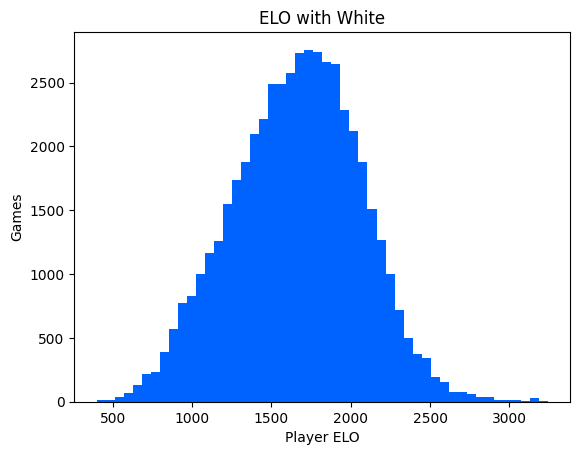

In [55]:
from matplotlib import pyplot as plot
fig, ax = plot.subplots()
plot.hist(sample['WhiteElo'], bins=50, color='#0062ff')
print(max(sample['WhiteElo']))
print(min(sample['WhiteElo']))

plot.title('ELO with White')
ax.set_xlabel('Player ELO')
ax.set_ylabel('Games')

plot.show()

3242
400


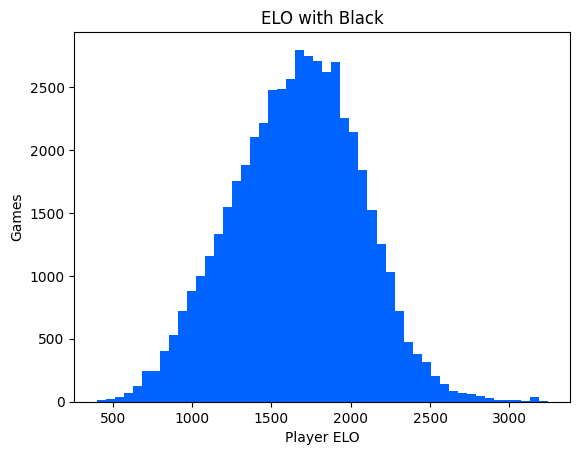

In [56]:
from matplotlib import pyplot as plot
fig, ax = plot.subplots()
plot.hist(sample['BlackElo'], bins=50, color='#0062ff')
print(max(sample['BlackElo']))
print(min(sample['BlackElo']))

plot.title('ELO with Black')
ax.set_xlabel('Player ELO')
ax.set_ylabel('Games')

plot.show()

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

N = 30   # number of plies to include
def head_n_moves(movetext, n=N):
    plies = movetext.split()
    return " ".join(plies[:n])

# build a corpus of “strings” of first N plies
sample["opening_sequence"] = sample["movetext"].apply(head_n_moves)
#TODO remove eval from strings
print(sample["opening_sequence"][94])
# vectorize
vec = CountVectorizer(token_pattern=r"[^ ]+")
X_moves = vec.fit_transform(sample["opening_sequence"])


1. e4 { [%clk 0:10:00] } 1... e5 { [%clk 0:10:00] } 2. Nf3 { [%clk 0:09:58] } 2... Nc6 { [%clk 0:09:56] } 3. Bc4 { [%clk 0:09:56] }


In [49]:
# one‑hot encode ECO
eco_dummies = pd.get_dummies(sample["ECO"], prefix="eco")

# assemble final design matrix
import scipy.sparse as sp
X = sp.hstack([X_moves, sp.csr_matrix(eco_dummies.values)])
y = sample["WhiteElo"]  # or BlackElo, or concatenate both as separate rows


In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [51]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 4.1 Ridge regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
pred = ridge.predict(X_test)
print("Ridge RMSE:", mean_squared_error(y_test, pred))
print("Ridge R²:", r2_score(y_test, pred))
print("Acc@±200 Elo: ", np.mean(np.abs(pred - y_test) <= 200) * 100)

# 4.2 Random forest
rf = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print("RF   RMSE:", mean_squared_error(y_test, pred_rf))
print("RF   R²:", r2_score(y_test, pred_rf))
print("Acc@±200 Elo: ", np.mean(np.abs(pred_rf - y_test) <= 200) * 100)


Ridge RMSE: 99889.36205800239
Ridge R²: 0.2025962143891895
Acc@±200 Elo:  46.894548704200176
RF   RMSE: 106101.05405948212
RF   R²: 0.15300908503949806
Acc@±200 Elo:  45.23011617515639


📊 Plotting True vs. Predicted Elo (Ridge Regression)…


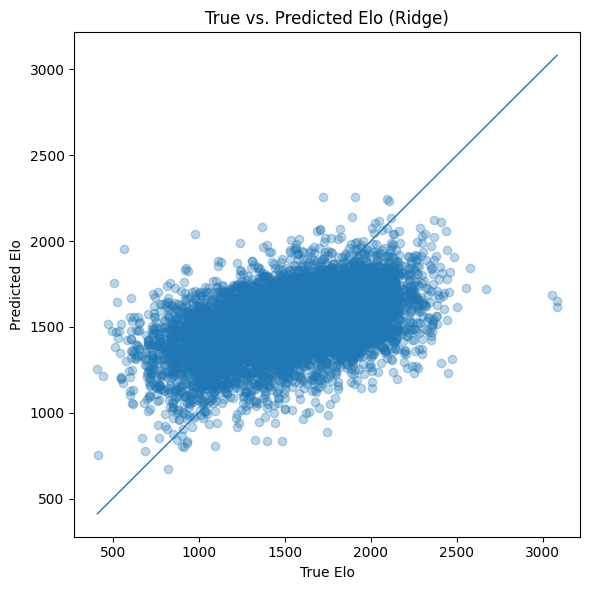

In [52]:
import matplotlib.pyplot as plt
print("📊 Plotting True vs. Predicted Elo (Ridge Regression)…")
plt.figure(figsize=(6,6))
plt.scatter(y_test, pred, alpha=0.3)
lims = [min(y_test.min(), pred.min()), max(y_test.max(), pred.max())]
plt.plot(lims, lims, linewidth=1)       # y=x line
plt.xlabel("True Elo")
plt.ylabel("Predicted Elo")
plt.title("True vs. Predicted Elo (Ridge)")
plt.tight_layout()
plt.show()